In [38]:
import pickle
import json
from random import randint, shuffle
from tqdm import tqdm
import numpy as np
import string
import re
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from collections import defaultdict
from espncricinfo.match import Match

In [5]:
def plotHist(data, bins=[], x_labels=True):
    data_hist = np.random.randn(82)
    fig, ax = plt.subplots(figsize=(24,5))
    if bins: 
        counts, bins, patches = ax.hist(data, bins=bins, facecolor='yellow', edgecolor='gray')
    else:
        counts, bins, patches = ax.hist(data, facecolor='yellow', edgecolor='gray')

    # Set the ticks to be at the edges of the bins.
    if x_labels:
        ax.set_xticks(bins)
        # Set the xaxis's tick labels to be formatted with 1 decimal place...
        ax.xaxis.set_major_formatter(FormatStrFormatter('%0.05f'))

    # Change the colors of bars at the edges...
    twentyfifth, seventyfifth = np.percentile(data_hist, [25, 75])
    for patch, rightside, leftside in zip(patches, bins[1:], bins[:-1]):
        if rightside < twentyfifth:
            patch.set_facecolor('green')
        elif leftside > seventyfifth:
            patch.set_facecolor('red')

    # Label the raw counts and the percentages below the x-axis...
    if x_labels:
        bin_centers = 0.5 * np.diff(bins) + bins[:-1]
        for count, x in zip(counts, bin_centers):
            # Label the raw counts
            ax.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
                xytext=(0, -18), textcoords='offset points', va='top', ha='center')

            # Label the percentages
            percent = '%0.0f%%' % (100 * float(count) / counts.sum())
            ax.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
                xytext=(0, -32), textcoords='offset points', va='top', ha='center')


    # Give ourselves some more room at the bottom of the plot
    plt.subplots_adjust(bottom=0.1)
    plt.show()

In [6]:
def load_data(filename):
    with open(f"{filename}.pkl", "rb") as f:
        data = pickle.load(f)
    print("Loaded data!")
    return data
        
def save_data(data, filename):
    with open(f"{filename}.pkl", "wb") as f:
        pickle.dump(data, f)
        
def export_to_json(data):
    with open('matches.json', 'w') as json_file:
        json.dump(data, json_file)
    
def getRandomMatch(data):
    return data[match_ids[randint(0, 1919)]]

def printInnings(data, matchId, inningsNum, summaries=False, highlightOnly=False):
    if summaries:
        for over in data[matchId]['commentary'][f'innings{inningsNum}']['over_summaries']:
            if highlightOnly:
                print(over[0])
            else:
                print(over)
    else:
        for ball in data[matchId]['commentary'][f'innings{inningsNum}']['balls']:
            print(ball)
            
i1 = lambda m : m['commentary']['innings1']
i2 = lambda m : m['commentary']['innings2']

In [652]:
data, players = load_data("matches_with_details"), load_data("player_table")

Loaded data!
Loaded data!


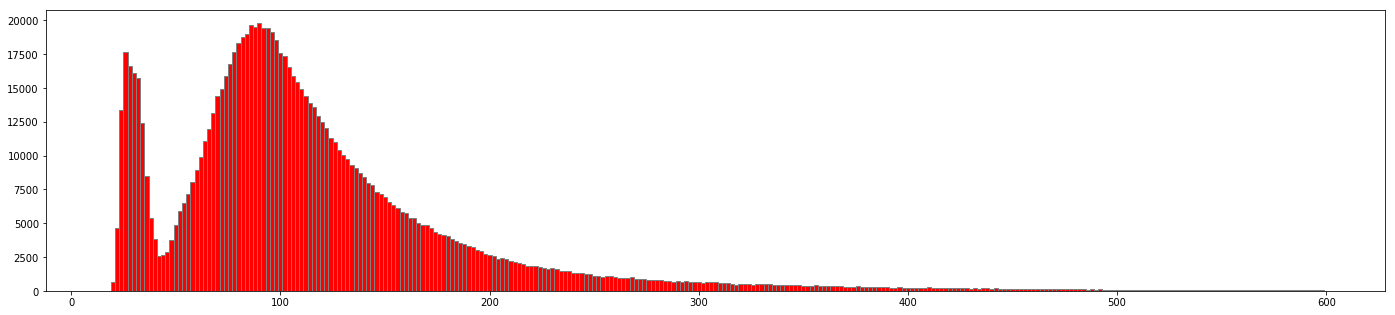

In [18]:
lengths = []
count = 0
over_summary = set()
ball_samples = defaultdict(list)
for i, m in data.items():
    for b in i1(m)['balls']:
        over_summary.add(b['number'])
        comms = b['desc']
        lengths.append(len(comms))
        ball_samples[len(comms)].append(comms)
        
    for b in i2(m)['balls']:
        over_summary.add(b['number'])
        lengths.append(len(b['desc']))

plotHist(lengths, bins=list(range(17,600, 2)), x_labels=False)

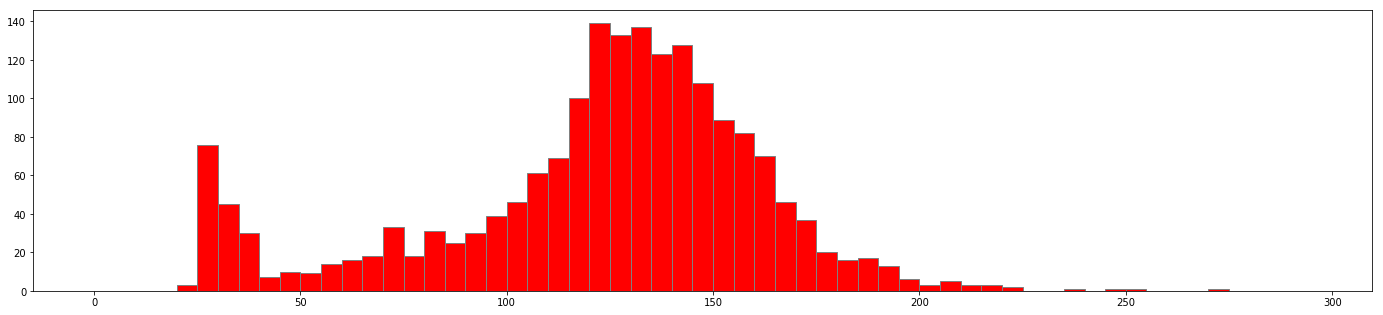

In [19]:
lengths = []
ball_samples = defaultdict(list)
for i, m in data.items():
    match_lengths = []
    for b in i1(m)['balls']:
        comms = b['desc']
        match_lengths.append(len(comms))
        
    for b in i2(m)['balls']:
        comms = b['desc']
        match_lengths.append(len(comms))
        
    avg_length = (sum(match_lengths)/len(match_lengths))
    ball_samples[avg_length // 5].append(i)
    lengths.append(avg_length)

plotHist(lengths, bins=list(range(0,300, 5)), x_labels=False)

In [20]:
total_with_commentary = 0
for k in sorted(ball_samples.keys()):
    if k >= 15:
        total_with_commentary += len(ball_samples[k])
print(total_with_commentary)

1608


In [21]:
def resetBalls():
    for i, m in data.items():
        newBalls = []
        for b in i1(m)['balls']:
            ball_data = {}
            ball_data['number'] = b[0]
            ball_data['outcome'] = b[1]
            ball_data['desc'] = ",".join(b[2::])
            ball_data['pitch'] = {}
            newBalls.append(ball_data)

        m['commentary']['innings1']['balls'] = newBalls
        newBalls = []
        for b in i2(m)['balls']:
            ball_data = {}
            ball_data['number'] = b[0]
            ball_data['outcome'] = b[1]
            ball_data['desc'] = ",".join(b[2::])
            ball_data['pitch'] = {}
            newBalls.append(ball_data)
        m['commentary']['innings2']['balls'] = newBalls

In [22]:
def downloadMatchDetails():
    count = 0
    for i, m in tqdm(data.items()):
        count += 1
        if not 'batting_first' in m:
            espnMatch = Match(i)
            m['batting_first'] = espnMatch.batting_first
            m['ground_id'] = espnMatch.ground_id
            m['home_team'] = espnMatch.home_team
        if count % 20 == 0:
            save_data(data, "matches_with_details")
    save_data(data, "matches_with_details")

In [206]:
import difflib
bf = set()
teams = set()
for i, m in data.items():
    bf.add(m['batting_first'])
    teams.add(m['team1'])
    teams.add(m['team2'])

team = {}
for t in teams:
    closest = difflib.get_close_matches(t.upper(), list(bf))
    team[t] = closest
team['Australia'] = ['AUS']
team['Zimbabwe'] = ['ZIM']
team['New Zealand'] = ['NZ']
team['West Indies'] = ['WI']
team['Pakistan'] = ['PAK']
team['Hong Kong'] = ['HKG']
team['Afghanistan'] = ['AFG']
team['South Africa'] = ['SA']
del team['Oman']
team['Sri Lanka'] = ['SL']
team['Netherlands'] = ['NL']

for k, v in team.items():
    team[k] = v[0]
team_to_id = team
id_to_team = {v: k for k, v in team_to_id.items()} 
team_to_id

{'P.N.G.': 'PNG',
 'India': 'INDIA',
 'Canada': 'CAN',
 'Kenya': 'KENYA',
 'New Zealand': 'NZ',
 'Nepal': 'NEPAL',
 'Ireland': 'IRE',
 'Hong Kong': 'HKG',
 'Scotland': 'SCOT',
 'Pakistan': 'PAK',
 'Namibia': 'NAM',
 'U.S.A.': 'USA',
 'Bangladesh': 'BDESH',
 'Zimbabwe': 'ZIM',
 'Sri Lanka': 'SL',
 'South Africa': 'SA',
 'U.A.E.': 'UAE',
 'West Indies': 'WI',
 'Australia': 'AUS',
 'Afghanistan': 'AFG',
 'Bermuda': 'BMUDA',
 'Netherlands': 'NL',
 'England': 'ENG'}

In [83]:
from difflib import SequenceMatcher
def getPlayerProfile(name):
    returnList = [] 
    for i, p in players.items():
        match = SequenceMatcher(a=p['known_as'].lower(), b=name.lower()).ratio()
        if match > 0.6:
            returnList.append((p, match))
            
    return [i[0] for i in sorted(returnList, key = lambda x : x[1], reverse=True)]

In [606]:
def getOver(balls, over):
    retBalls = []
    for i, b in enumerate(balls):
        if overNum == int(b['over']):
            retBalls.append(i)
    return retBalls

def getPlayerBalls(profile, innings, i):
    bowler_map = defaultdict(list)
    sums = innings['over_summaries']
    balls = []
    for idx in reversed(range(len(sums))):
        summary = sums[idx]
        if summary['next_bowler'] == profile['known_as']:
            balls += getOver(innings['balls'], int(summary['number'])-1)
     
    return sorted(balls)

In [632]:
def getAllPlayerOvers(playerName):
    overs = []
    profile = getPlayerProfile(playerName)[0]
    p_id = profile['player_id']
    for i, m in data.items():
        # Check which team player is in, if any
        if p_id in m['team_1_players']:
            teamNum = 1
        elif p_id in m['team_2_players']:
            teamNum = 2
        else:
            continue
            
        team = m[f'team{teamNum}']
        
        # Check which innings player bowled in
        team_id = team_to_id[team]
        inn = 1
        if team_id == m['batting_first']:
            inn = 2
            
        # Get all balls from match
        balls = getPlayerBalls(profile, m['commentary'][f'innings{inn}'], i)
        if balls:
            overs.append((i, inn, balls))
            
    return overs

In [634]:
def printBowlerBalls(name, onlyCount = True, outcome = None):
    matches = getAllPlayerOvers(name)
    num_balls = sum(list(map(lambda x : len(x[2]), matches)))
    print(f"{len(matches)} innings | {num_balls} balls")
    num_balls = 0
    for i, inn, playerBalls in matches:
        balls = data[i]['commentary'][f'innings{inn}']['balls']
        for b in playerBalls:
            if not outcome or balls[b]['outcome'] == outcome:
                num_balls += 1
                if not onlyCount: print(f"{balls[b]['number']:<5} | {balls[b]['desc'][:180]:<180}")
    if outcome:
        print(f'\n{num_balls} {outcome}s')

In [637]:
printBowlerBalls("Mitchell Starc", True, 'W')

85 innings | 4446 balls

164 Ws


# All possible roles

In [640]:
def getRoles():
    roles = set()
    for i, m in data.items():
        for p in m['team_1_players']:
            roles.add(players[p]['player_primary_role'])
        for p in m['team_2_players']:
            roles.add(players[p]['player_primary_role'])
    return roles
getRoles()

{None,
 'allrounder',
 'batsman',
 'batting allrounder',
 'bowler',
 'bowling allrounder',
 'middle-order batsman',
 'opening batsman',
 'top-order batsman',
 'wicketkeeper',
 'wicketkeeper batsman'}

# Further Data Extraction from Comms

In [329]:
def extractBowlerPatterns():
    bowlerPattern = "^(?P<bowler>[\w \-'?]+) to (?P<batsman>[\w \-']+),"
    count = 0
    overall = 0
    for i, m in data.items():
        i1balls = i1(m)['balls']
        for idx in range(len(i1balls)):
            b = i1balls[idx]
            match = re.match(bowlerPattern, b['desc'])
            bowler = match.group('bowler')
            batsman = match.group('batsman')
            m['commentary']['innings1']['balls'][idx]['bowler'] = bowler
            m['commentary']['innings1']['balls'][idx]['batsman'] = batsman

        i2balls = i2(m)['balls']
        for idx in range(len(i2balls)):
            b = i2balls[idx]
            match = re.match(bowlerPattern, b['desc'])
            bowler = match.group('bowler')
            batsman = match.group('batsman')
            m['commentary']['innings2']['balls'][idx]['bowler'] = bowler
            m['commentary']['innings2']['balls'][idx]['batsman'] = batsman


In [653]:
overNumberPattern = '^(?P<over>\d+)\.(?P<ball>\d+)$'
def extractOverNums():
    for i, m in data.items():
        i1balls = i1(m)['balls']
        for idx in range(len(i1balls)):
            b = i1balls[idx]
            match = re.match(overNumberPattern, b['number'])
            over = match.group('over')
            ball = match.group('ball')
            m['commentary']['innings1']['balls'][idx]['over'] = over
            m['commentary']['innings1']['balls'][idx]['delivery'] = ball
            
        i2balls = i2(m)['balls']
        for idx in range(len(i2balls)):
            b = i2balls[idx]
            match = re.match(overNumberPattern, b['number'])
            over = match.group('over')
            ball = match.group('ball')
            m['commentary']['innings2']['balls'][idx]['over'] = over
            m['commentary']['innings2']['balls'][idx]['delivery'] = ball

extractOverNums()

In [331]:
save_data(data, "matches_with_details")

In [332]:
export_to_json(data)